# Предсказание стоимости жилья

В проекте нам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. 

На первом этапе мы познакомимся с данными, произведем предобработку данных, разобьем данные на выборки.  Далее мы обучим модель и сделаем предсказания на тестовой выборке. Мы построим две модели линейной регрессии на разных наборах данных: используя все данные; используя только числовые переменные, исключив категориальные. Для оценки качества модели будут использоваться метрики RMSE, MAE и R2.

## Обзор данных

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns


import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 2022

spark = SparkSession.builder \
                    .master("local") \
                    .appName("EDA California Housing") \
                    .getOrCreate()

df = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True) 

В колонках датасета содержатся следующие данные:

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану;

Выведите названия колонок и их тип данных 

In [2]:
# представьте результат в виде таблицы pandas
pd.DataFrame(df.dtypes, columns=['column', 'type']).head(11)

,column,type
0,longitude,double
1,latitude,double
2,housing_median_age,double
3,total_rooms,double
4,total_bedrooms,double
5,population,double
6,households,double
7,median_income,double
8,median_house_value,double
9,ocean_proximity,string


В большинстве колонок хранятся количественные данные, кроме одной — `ocean_proximity`. Она хранит категориальные значения.

Выведем первые 10 строк датасета

In [3]:
df.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Выведем базовые описательные статистики данных в виде таблицы в pandas

In [4]:
df.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


Мы видим, что таблица насчитывает 20640 строк. Максимальная медианная стоимость дома составляет полмиллиона долларов.

Проверим количество пропусков в каждой колонке

In [5]:
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
         ).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



В колонке total_bedrooms имеются пропуски в количестве 207 шт. Заполних им медианным значением столбца.

In [6]:
imputer = Imputer(
    inputCols=['total_bedrooms'],
    outputCols=['{}_imputed'.format(c) for c in ['total_bedrooms']]
    ).setStrategy('median') 

In [7]:
df = imputer.fit(df).transform(df)

В таблицу был добавлен новый столбец `total_bedrooms_imputed`, в котором пропущенные значения были заполнены с помощью медианы. Оставим эту колонку в качестве основной, а колонку `total_bedrooms` удалим

In [8]:
df = df.drop('total_bedrooms')

Проверим результат

In [9]:
df.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,total_bedrooms_imputed
0,count,20640,20640,20640,20640,20640,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None,536.8388565891473
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None,419.39187792168866
3,min,-124.35,32.54,1.0,2.0,3.0,1.0,0.4999,14999.0,<1H OCEAN,1.0
4,max,-114.31,41.95,52.0,39320.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN,6445.0


Также удалим колонки с данными широты и долготы, так как они не представляют особой ценности для построения модели и могут только увеличить время обучения.

In [10]:
df = df.drop('longitude', 'latitude')

Исходя из имеющихся данных, выведем дополнительные показатели, которые могут быть полезными признаками для модели машинного обучения. Добавим соответствующие колонки в таблицу.

- Отношение количества комнат `total_rooms` к количеству домовладений `households`. Назовите колонку `rooms_per_household`.
- Отношение количества жителей `population` к количеству домовладений `households`. Назовите колонку `population_in_household`.
- Отношение количества спален `total_bedrooms` к общему количеству комнат `total_rooms`. Назовите колонку `bedroom_index`.

In [11]:
df = df.withColumn('rooms_per_household', F.col('total_rooms') / F.col('households'))
df = df.withColumn('population_in_household', F.col('population') / F.col('households'))
df = df.withColumn('bedroom_index', F.col('total_bedrooms_imputed') / F.col('total_rooms'))

df.printSchema()

root
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- total_bedrooms_imputed: double (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



- **Столбчатый график проживания самых обеспеченых людей**

Найдем жилые массивы, в которых живут самые обеспеченные люди. Сгруппируем данные по столбцу с категориями удалённости от океана и посчитаем среднее значение медианного дохода в жилом массиве.

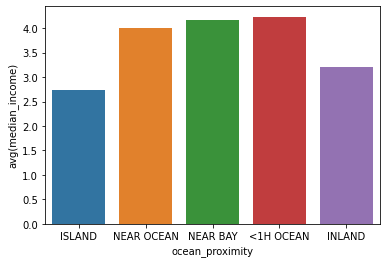

In [12]:
df_wealthy = df.groupBy('ocean_proximity').agg(F.avg('median_income')).toPandas()
sns.barplot(x='ocean_proximity', y='avg(median_income)', data=df_wealthy);

Ожидаемый результат: люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива.

- **Линейный график зависимости возраста жителей от удалённости жилого массива от океана**

Исследуем зависимость возраста жителей от удалённости жилого массива от океана. Сгруппируем данные по двум столбцам: медианный возраст жителей и удалённость от океана. Посчитаем, сколько раз встречается то или иное медианное значение возраста в зависимости от удалённости от океана.

<AxesSubplot:xlabel='housing_median_age', ylabel='count'>

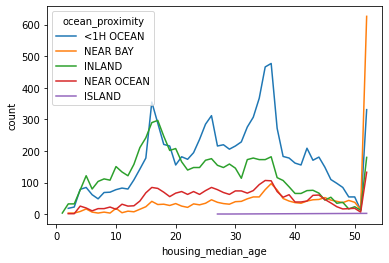

In [13]:
df_ages = df.groupBy('housing_median_age', 'ocean_proximity').count().toPandas()

sns.lineplot(data=df_ages, 
    x='housing_median_age', 
    y='count', 
    hue='ocean_proximity'
)

По графику можно предположить, что люди до 20 лет чаще живут в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана. Старшие поколения предпочитают селиться в радиусе часа езды до океана и около залива.

## Подготовка данных

Разделим колонки на два типа: числовые и текстовые, которые представляют категориальные данные.

In [14]:
categorical_cols = ['ocean_proximity']
numerical_cols = ['housing_median_age', 'total_rooms', 'total_bedrooms_imputed', 'population', 'households', 'median_income',
                 'rooms_per_household', 'population_in_household', 'bedroom_index']
target = 'median_house_value'

- **Трансформация категорийных признаков**

Трансформируем категориальные признаки в числовые. 

In [15]:
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols]) 
df = indexer.fit(df).transform(df)

cols = [c for c in df.columns for i in categorical_cols if (c.startswith(i))]
df.select(cols).show(5) 

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
+---------------+-------------------+
only showing top 5 rows



Дополнительно создадим OHE-кодирование для категорий.

In [16]:
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
                        outputCols=[c+'_ohe' for c in categorical_cols])
df = encoder.fit(df).transform(df)

cols = [c for c in df.columns for i in categorical_cols if (c.startswith(i))]
df.select(cols).show(3) 

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



Объединим признаки в один вектор, с которым ML-алгоритм умеет работать.

In [17]:
categorical_assembler = \
        VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                                        outputCol="categorical_features")
df = categorical_assembler.transform(df) 

- **Трансформация числовых признаков**

Для числовых признаков произведем шкалирование значений, чтобы сильные выбросы не смещали предсказания модели.

In [18]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols,
                                                                            outputCol="numerical_features")
df = numerical_assembler.transform(df) 

In [19]:
standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
df = standardScaler.fit(df).transform(df) 

После всех трансформаций получается такая таблица:

In [20]:
df.columns

['housing_median_age',
 'total_rooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'total_bedrooms_imputed',
 'rooms_per_household',
 'population_in_household',
 'bedroom_index',
 'ocean_proximity_idx',
 'ocean_proximity_ohe',
 'categorical_features',
 'numerical_features',
 'numerical_features_scaled']

В конце соберем трансформированные категорийные и числовые признаки с помощью `VectorAssembler`

In [21]:
all_features = ['categorical_features','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='features') 
df = final_assembler.transform(df)

df.select(all_features).show(3) 

+--------------------+-------------------------+
|categorical_features|numerical_features_scaled|
+--------------------+-------------------------+
|       (4,[3],[1.0])|     [3.25770230160830...|
|       (4,[3],[1.0])|     [1.66857922765303...|
|       (4,[3],[1.0])|     [4.13171999228370...|
+--------------------+-------------------------+
only showing top 3 rows



## Обучение моделей

### Модель линейной регрессии построенная на всех данных

Разделяем наш датасет на две части — выборку для обучения и выборку для тестирования качества модели.

In [22]:
train_data, test_data = df.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count()) 

16418 4222


Обучим модель 

In [23]:
lr = LinearRegression(labelCol=target, featuresCol='features')
model = lr.fit(train_data)

23/01/26 19:52:49 WARN Instrumentation: [5230d633] regParam is zero, which might cause numerical instability and overfitting.
23/01/26 19:52:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/01/26 19:52:50 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/01/26 19:52:50 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/01/26 19:52:50 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Предскажем результаты и выведем таблицу с колонкой предсказания модели и колонкой медианной стоимости.

In [24]:
predictions = model.transform(train_data)

predictedLabes = predictions.select("median_house_value", "prediction")
predictedLabes.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           55000.0| 37410.55271672869|
|          141700.0|153407.80169744598|
|          189200.0|145622.31634873027|
|           47500.0|175035.09680222094|
|           60000.0| 144765.6052345728|
|          350000.0|  646256.044327012|
|          164800.0| 84253.49978744662|
|          500001.0| 363757.9267769991|
|          310000.0|309305.46957226767|
|          166500.0| 169121.5756242315|
|          237500.0|180066.66514306178|
|          450000.0|130603.22985678047|
|          425000.0| 231417.5144761036|
|          275000.0| 227291.2991922631|
|          133600.0| 77145.67733570171|
|          114200.0| 87140.13459245529|
|          111100.0|170991.89575405646|
|          298500.0| 309483.4278240995|
|          240200.0|190291.88737314416|
|          331400.0|344496.56023671024|
+------------------+------------------+
only showing top 20 rows



Выполним ту же операцию на тестовой выборке

In [25]:
predictions = model.transform(test_data)

predictedLabes = predictions.select("median_house_value", "prediction")
predictedLabes.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          191300.0| 171021.7967374883|
|          434700.0| 148857.6727325565|
|          500001.0|309918.82800596807|
|          315000.0| 132997.8811686493|
|          100000.0| 123239.9271153414|
|          136700.0|169185.15358620894|
|          145600.0|203126.38473166223|
|          158500.0| 235931.0385611431|
|          196700.0|202080.15172150405|
|           96500.0| 146044.9357546253|
|          111500.0|139323.56395735906|
|          137900.0|134945.93134843503|
|          500001.0|440346.82267734944|
|          204400.0|232246.15859672992|
|          222500.0|223323.94085788383|
|          187800.0|170713.60557718138|
|          220800.0|205685.79346504685|
|          151300.0|175378.22228518006|
|          163500.0|119014.52320808027|
|          500001.0|346239.55160448496|
+------------------+------------------+
only showing top 20 rows



- **Оценим качество модели**

Показатели обучающей выборки

In [26]:
trainingSummary = model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("MAE: %f" % trainingSummary.meanAbsoluteError)
print("R2: %f" % trainingSummary.r2)

RMSE: 69493.912573
MAE: 49968.631359
R2: 0.633830


Показатели тестовой выборки

In [27]:
test_result = model.evaluate(test_data)
print("RMSE %f" % test_result.rootMeanSquaredError)
print("MAE: %f" % test_result.meanAbsoluteError)
print("R2: %f" % test_result.r2)

RMSE 69590.776208
MAE: 50632.164885
R2: 0.649137


- Среднеквадратичная ошибка (RMSE) показывает разность между предсказанными и наблюдаемыми значениями в модели. 
- Среднее абсолютное отклонение (MAE) - это средняя абсолютная разность между предсказанием модели и целевым значением  


Тенденция к понижению данных метрик указывает, что показатель улучшается. Это означает, что переподготовка модели эффективна.

- Метрика R2 (коэффициент детерминации) вычисляет долю средней квадратичной ошибки модели от MSE среднего, а затем вычитает эту величину из единицы. Чем выше показатель, тем лучше предсказания соответствуют реальым данным. Следовательно увеличение метрики на тестовой выборке означает прирост качества модели. 

### Модель линейной регрессии построенная на числовых переменных

Рассмотрим какие колонки имеются в таблице

In [28]:
df.columns

['housing_median_age',
 'total_rooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'total_bedrooms_imputed',
 'rooms_per_household',
 'population_in_household',
 'bedroom_index',
 'ocean_proximity_idx',
 'ocean_proximity_ohe',
 'categorical_features',
 'numerical_features',
 'numerical_features_scaled',
 'features']

Удалим столбцы, которые нам не нужны для построения модели

In [29]:
df = df.drop('ocean_proximity_idx', 'ocean_proximity_ohe', 'categorical_features', 'features')

В конце соберем трансформированные числовые признаки с помощью `VectorAssembler`

In [30]:
features_zero = ['numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=features_zero, 
                                  outputCol='features_new') 
df = final_assembler.transform(df)

df.select(features_zero).show(3) 

+-------------------------+
|numerical_features_scaled|
+-------------------------+
|     [3.25770230160830...|
|     [1.66857922765303...|
|     [4.13171999228370...|
+-------------------------+
only showing top 3 rows



Итоговый список столбцов

In [31]:
df.columns

['housing_median_age',
 'total_rooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'total_bedrooms_imputed',
 'rooms_per_household',
 'population_in_household',
 'bedroom_index',
 'numerical_features',
 'numerical_features_scaled',
 'features_new']

Разобьем данные на выборки

In [32]:
train_data, test_data = df.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count()) 

16418 4222


Обучим модель

In [33]:
lr = LinearRegression(labelCol=target, featuresCol='features_new')
model = lr.fit(train_data)

23/01/26 19:52:58 WARN Instrumentation: [9c93b06e] regParam is zero, which might cause numerical instability and overfitting.


Предскажем результаты

In [34]:
predictions = model.transform(train_data)

predictedLabes = predictions.select("median_house_value", "prediction")
predictedLabes.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           55000.0| 58447.70108787919|
|          141700.0|184486.79771659052|
|          189200.0|140474.35647652904|
|           47500.0| 210522.8073048595|
|           60000.0| 97435.41914518888|
|          350000.0| 664407.9149742833|
|          164800.0| 98317.39198262288|
|          500001.0| 343882.6029052862|
|          310000.0| 285503.1531490514|
|          166500.0|195759.52266468492|
|          237500.0|138055.09586582304|
|          450000.0| 80650.40096130144|
|          425000.0|208787.37741129857|
|          275000.0|204167.57596052001|
|          133600.0| 90079.48145287135|
|          114200.0| 100595.7245299046|
|          111100.0|204114.99474755075|
|          298500.0| 281304.3605049918|
|          240200.0| 214474.2377744309|
|          331400.0|315962.60403971135|
+------------------+------------------+
only showing top 20 rows



In [35]:
predictions = model.transform(test_data)

predictedLabes = predictions.select("median_house_value", "prediction")
predictedLabes.show()

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          191300.0|199016.80632188742|
|          434700.0| 98772.96526932874|
|          500001.0| 281698.3646231628|
|          315000.0|141268.14887768903|
|          100000.0|144580.07880879287|
|          136700.0|204605.62293251965|
|          145600.0|160590.79533357377|
|          158500.0| 188910.4925379794|
|          196700.0|228148.04987558618|
|           96500.0|172627.04145367804|
|          111500.0|165885.23632950455|
|          137900.0|160343.09144319457|
|          500001.0|421996.02613194514|
|          204400.0| 255663.5146467082|
|          222500.0|239755.30298795755|
|          187800.0|174037.08006068977|
|          220800.0|223140.54735602555|
|          151300.0|177418.22991468228|
|          163500.0|138294.52219822205|
|          500001.0|327157.82018351834|
+------------------+------------------+
only showing top 20 rows



In [36]:
trainingSummary = model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("MAE: %f" % trainingSummary.meanAbsoluteError)
print("R2: %f" % trainingSummary.r2)

RMSE: 75374.360605
MAE: 54862.598528
R2: 0.569239


In [37]:
test_result = model.evaluate(test_data)
print("RMSE %f" % test_result.rootMeanSquaredError)
print("MAE: %f" % test_result.meanAbsoluteError)
print("R2: %f" % test_result.r2)

RMSE 74983.352986
MAE: 55523.140186
R2: 0.592654


Исключив колонку, содержащую категориальное значение, мы получили модель, у которой RMSE, MAE значительно увеличились; R2 уменьшилось. Из этого можно сделать вывод, что данная модель ниже качеством.

## Анализ результатов

В проекте нам нужно было обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. Основываясь на этих данных мы предсказывали медианную стоимость дома в жилом массиве. 

На первом этапе мы познакомимся с данными, избавились от пропусков, ознакомились со статистическими показателями. Максимальная медианная стоимость дома составляет полмиллиона долларов.

Далее мы избавились от колонок, не представляющих значимости в процессе обучения модели и добавили дополнительные показатели, которые могут быть полезными признаками для модели машинного обучения.

- Отношение количества комнат `total_rooms` к количеству домовладений `households`. Назовите колонку `rooms_per_household`.
- Отношение количества жителей `population` к количеству домовладений `households`. Назовите колонку `population_in_household`.
- Отношение количества спален `total_bedrooms` к общему количеству комнат `total_rooms`. Назовите колонку `bedroom_index`.

Также по данным, мы отметили, что:
- Люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива.
- Люди до 20 лет чаще живут в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана. Старшие поколения предпочитают селиться в радиусе часа езды до океана и около залива.

После этого мы трансформировали категориальный признак в числовое представление, а также в OHE. Для числовых признаков произвели шкалирование значений — чтобы сильные выбросы не смещали предсказания модели. В конце собрали трансформированные категорийные и числовые признаки.

На следующем этапе мы построили две модели линейной регрессии на разных наборах данных:  
- используя все данные из файла;
- используя только числовые переменные, исключив категориальные.
Также произвели оценку качества моделей с помощью метрик RMSE, MAE и R2. 

Показатели первой модели (все данные):
- RMSE 67832.481770
- MAE: 49175.320697
- R2: 0.654318
Показатели второй моделии (только числовые переменные):
- RMSE 73035.158197
- MAE: 53304.450319
- R2: 0.599257

Обе модели показали прирост качества на тестовой выборке. 

Исключив колонку, содержащую категориальное значение, мы получили модель, у которой RMSE, MAE значительно увеличились; R2 уменьшилось. Из этого можно сделать вывод, что данная модель ниже качеством.